In [27]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

<Axes: >

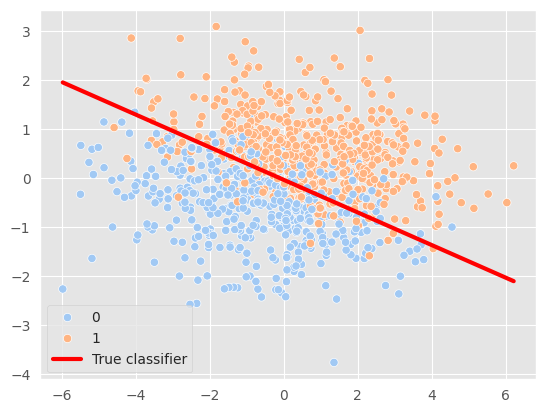

In [28]:
# Line parameters
# Multiplying the weights with a scalar will change randomness keeping the boundary constant
w1, w2, b = (1,3,0.1) 

def get_y(x, w1, w2, b):
  return -(w1*x + b)/w2
def get_distance(x, y):
  """Finds distance of point (x,y)  from line $w1 *x +w2 * y + b$"""
  return (w1 * x+ w2*y +b) #/ np.linalg.norm([w1, w2]) - intentionally not normalizing as the model does the same.
def sigmoid(x):
  return 1/(1 + np.exp(-x))
def positive_prob(distance):
  """Applies sigmoid to the distance.
  
  Args:
    distance: Distance of point from the line.
              Distance 0 will be 50-50 probability.
              Positive distance will result in p >0.5
  """
  p= sigmoid(distance)
  return float(format(p,".2f"))
def get_class(positive_prob):
  """Samples labels based on probability.

    Args:
      positive_prob: probability that label is 1
  """
  return np.random.choice([1,0], size = None, p = [positive_prob,1-positive_prob])

# Random dataset sampled from a gaussian distribution.
x = np.random.normal(0,2, size = (1000,))
y = np.random.normal(0,1, size = (1000,))

df = pd.DataFrame({'x': x,'y':y})

df['distance'] = df.apply(lambda row: get_distance(row.x, row.y), axis = 1)
df['label'] = df.distance.apply( lambda d: get_class(positive_prob(d)))

# couple of points on the line needed to plot.
online_x = np.array([x.min(), x.max()])
online_y = get_y(online_x, w1, w2, b)

sns.scatterplot(df, x= x, y = y, hue = 'label', palette = 'pastel')
sns.lineplot(x= online_x, y = online_y, color = 'red', linewidth = 3, label = 'True classifier')

In [29]:
class LogisticRegressionModel(nn.Module):
  @nn.compact
  def __call__(self, xy):
    return nn.Dense(features=1)(xy)
    # w1 = self.param('w1', init_fn = lambda key: jax.random.normal(key))
    # w2 = self.param('w2', init_fn = lambda key: jax.random.normal(key))
    # b = self.param('b', init_fn = lambda key: 0.0)
    # return w1 * xy[0, None] + w2 * xy[1, None] + b
  

model = LogisticRegressionModel()
params = model.init(jax.random.PRNGKey(45), jnp.array([0, 0]))
params

{'params': {'Dense_0': {'kernel': Array([[-0.47644362],
          [ 1.3919877 ]], dtype=float32),
   'bias': Array([0.], dtype=float32)}}}

In [30]:
def loss(params, apply_fn, xy, labels):
  logits = apply_fn(params, xy)
  return optax.sigmoid_binary_cross_entropy(logits, labels)

In [31]:
def loss_vectorized(params, apply_fn, xy, labels):
  l = jax.vmap(loss, in_axes=[None, None,0,0])(params, apply_fn, xy, labels)
  return jnp.mean(l)
value_and_grad = jax.value_and_grad(loss_vectorized)
# value_and_grad_vectorized = jax.vmap(value_and_grad, in_axes = (jax.tree_util.tree_map(lambda x: None, params),None, 0,0,0 ))

optimizer = optax.sgd(learning_rate = 0.1)
optimizer_state = optimizer.init(params)

def update_weights(params, optimizer_state, x, y, label,  apply_fn, optimizer):
  l, grad = value_and_grad(params, apply_fn, jnp.stack([x, y], axis=-1), label)
  grad = jax.tree_util.tree_map(jnp.mean, grad)
  weight_updates, new_states =  optimizer.update(grad, optimizer_state)
  new_params = optax.apply_updates(params, weight_updates)
  return new_params, new_states, l

In [32]:
def accuracy(y_true, y_pred):
  return jnp.mean(y_true == y_pred)

In [33]:
optimizer = optax.sgd(learning_rate = 0.3)
optimizer_state = optimizer.init(params)

def train_epoch(params, optimizer_state):
  new_params, new_states, l = update_weights(params,
                                          optimizer_state,
                                          df.x.values,
                                          df.y.values,
                                          df.label.values,
                                          model.apply,
                                          optimizer)
  logits = model.apply(new_params, jnp.stack([df.x.values, df.y.values], axis=-1))
  positive = jnp.array(logits)>0.5
  preds = jnp.array(positive, dtype = int)
  acc = accuracy(df.label.values, preds)
  return new_params, new_states, l, acc

Text(0.5, 1.0, 'Before Training')

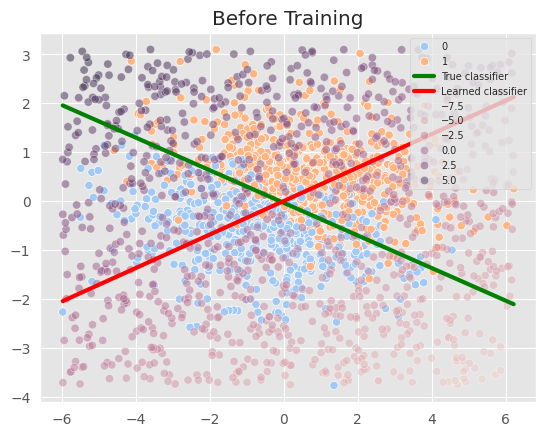

In [34]:
def plot_result(ax, params, epoch, accuracy, loss):
  online_x = np.array([x.min(), x.max()])
  original_y = get_y(online_x, w1,w2,b)
  
  dense = params['params']['Dense_0']
  w1_n, w2_n, b_n = dense['kernel'][0], dense['kernel'][1], dense['bias']
  
  # p = params['params']
  # w1_n, w2_n, b_n = p['w1'], p['w2'], p['b']
  new_y = get_y(online_x, w1_n, w2_n, b_n)

  sampled_x = jax.random.uniform(jax.random.key(0), shape=(1000,)) * (x.max() - x.min()) + x.min()
  sampled_y = jax.random.uniform(jax.random.key(1), shape=(1000,)) * (y.max() - y.min()) + y.min()
  new_z = jax.vmap(model.apply, in_axes=[None, 0])(params, jnp.stack([sampled_x, sampled_y], axis=-1))

  sns.scatterplot(df, x= x, y = y, hue = 'label', palette = 'pastel', ax = ax)
  sns.lineplot(x= online_x, y = original_y, color = 'green', linewidth = 3, label='True classifier', ax = ax)
  sns.lineplot(x= online_x, y = new_y, color = 'red', linewidth = 3, label='Learned classifier', ax = ax)
  sns.scatterplot(x= sampled_x.squeeze(), y = sampled_y.squeeze(), hue=new_z.squeeze(), alpha = 0.5, ax = ax)
  ax.legend(fontsize = 7)
  ax.set_title(f'Epoch: {epoch} : accuracy: {accuracy:.2f}, loss:{loss:.2f}', fontsize = 10)
fig, ax = plt.subplots(1,1,)
plot_result(ax, params, 0,0,0)
ax.set_title('Before Training')

  0%|          | 0/100 [00:00<?, ?it/s]

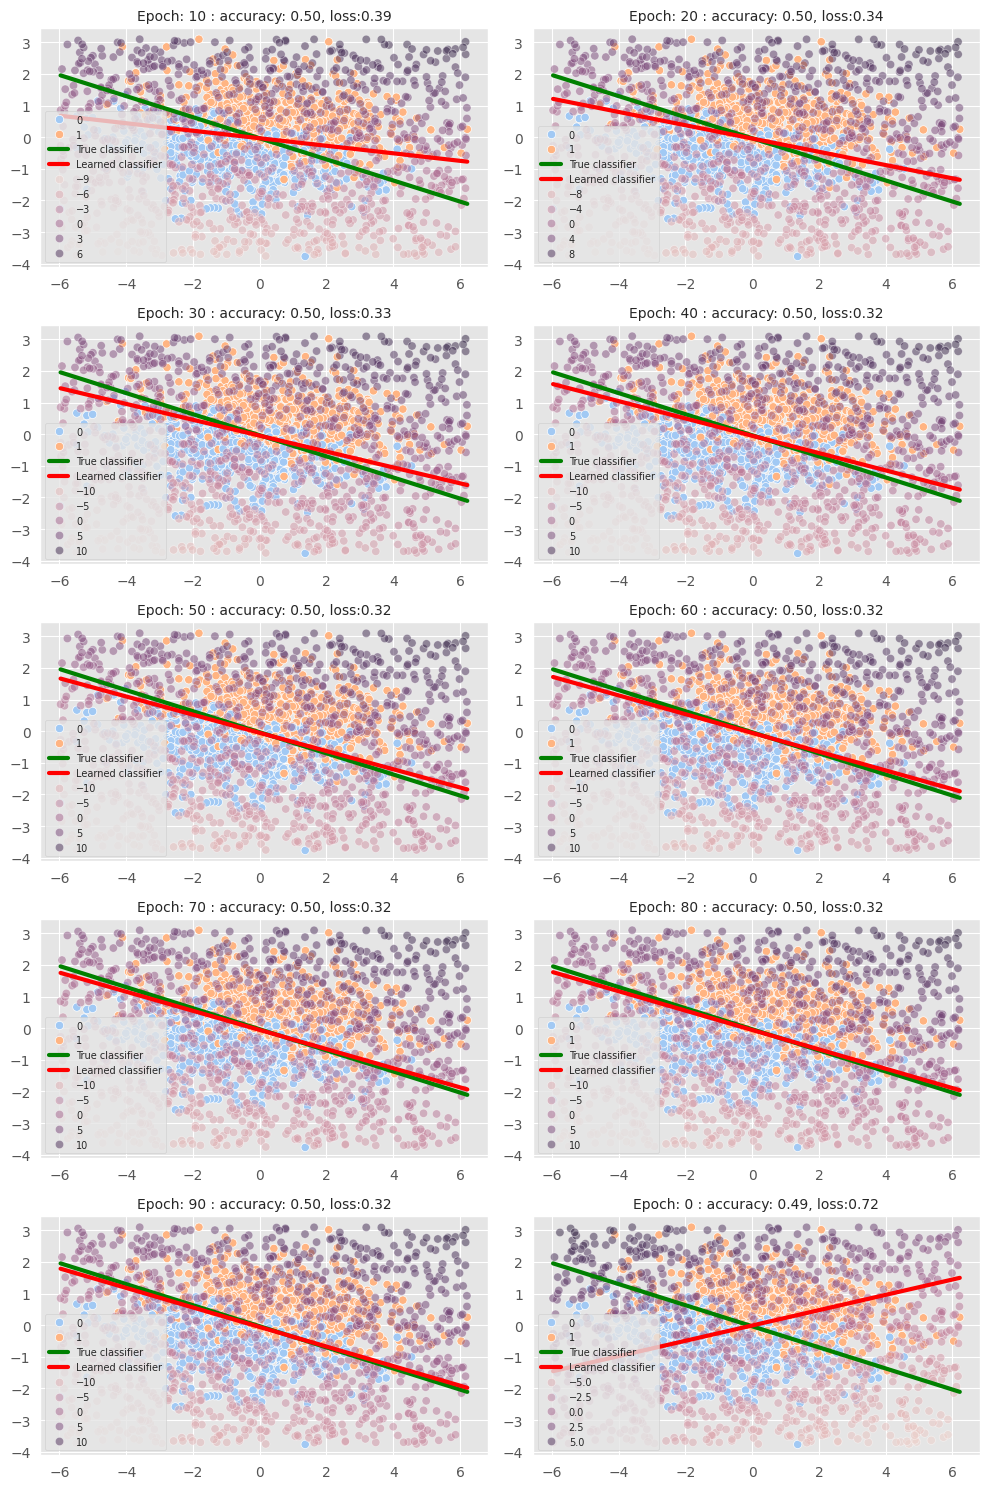

In [35]:
from tqdm.auto import trange
epochs = 100

fig, axes = plt.subplots(5,2, figsize = (10,15))
axes = axes.flatten()
for epoch in trange(0, epochs):
  params, optimizer_states, l, acc = train_epoch(params, optimizer_state)
  if epoch % 10 == 0:
    plot_result(axes[epoch//10-1], params, epoch, acc, l)
plt.tight_layout()

In [36]:
params

{'params': {'Dense_0': {'bias': Array([0.15431842], dtype=float32),
   'kernel': Array([[0.8418635],
          [2.7102952]], dtype=float32)}}}

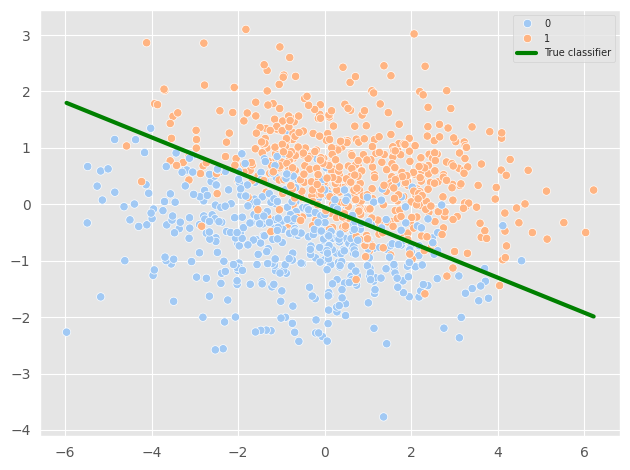

In [37]:
fig, ax = plt.subplots(1,1,)
online_x = np.array([x.min(), x.max()])
dense = params['params']['Dense_0']
w1_n, w2_n, b_n = dense['kernel'][0], dense['kernel'][1], dense['bias']
# w1_n, w2_n, b_n
original_y = get_y(online_x, w1_n,w2_n,b_n)
# 
# sampled_x = jax.random.uniform(jax.random.key(0), shape=(1000,)) * (x.max() - x.min()) + x.min()
# sampled_y = jax.random.uniform(jax.random.key(1), shape=(1000,)) * (y.max() - y.min()) + y.min()
# new_y = jax.vmap(model.apply, in_axes=[None, 0])(params, jnp.stack([sampled_x, sampled_y], axis=-1))

sns.scatterplot(df, x= x, y = y, hue = 'label', palette = 'pastel', ax = ax)
sns.lineplot(x= online_x, y = original_y, color = 'green', linewidth = 3, label='True classifier', ax = ax)
# sns.scatterplot(x= sampled_x.squeeze(), y = sampled_y.squeeze(), hue=new_y.squeeze(), alpha = 0.5, ax = ax)
ax.legend(fontsize = 7)
plt.tight_layout()

In [49]:
logits = jax.vmap(model.apply, in_axes=[None, 0])(params, jnp.stack([df.x.values, df.y.values], axis=-1))
positive = jnp.array(logits)>0.5
preds = jnp.array(positive, dtype = int)
acc = accuracy(df.label.values, preds)
acc

Array(0.50245, dtype=float32)

In [ ]:
loss_vectorized(params, model.apply, jnp.stack([df.x.values, df.y.values], axis=-1), df.label.values)